In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns
import shutil
from sklearn.utils import shuffle

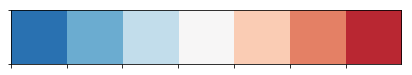

In [4]:
import seaborn as sns
sns.palplot(sns.color_palette("RdBu_r", 7))

sns.set_style("whitegrid")

# Importando base de dados

<p>Base com todos os dados do sudeste</p>

In [5]:
df = pd.read_csv('../data/sudeste.csv',low_memory=False)
print len(df)

9779168


<p>Base com todas chuvas EXTREMAS com inicio e fim de cada chuva extrema (> 50mm em 24 horas)</p>

In [6]:
dfhr = pd.read_csv('../data/extreme_prcp_evolution.csv')
print len(dfhr)

31710


<p>Subconjunto da base principal considerando o inicio e fim das chuvas extremas (> 50mm em 24 horas)</p>

In [7]:
dfext = pd.read_csv('../data/sudeste_extreme_prcp.csv', index_col=0)
print len(dfext)

761040


# Pré-processamento

<h3>Limpeza dos dados</h3>

In [8]:
# Campos não numericos e campos derivados
DES= ['wsid','wsnm','elvt','lat','lon','inme','city','prov']
INT = ['yr','mo','da','hr']
DAT = ['mdct','date']
DER = ['smax','smin','tmax','tmin','dmax','dmin','hmax','hmin']

In [9]:
# dataframe apenas com os dados continuos
dfcont = df
for f in DES + INT + DAT:    
    dfcont = dfcont.drop(f, 1)

In [10]:
dfcont = dfcont.apply(pd.to_numeric, errors='coerce')  

In [11]:
dfcont.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9779168 entries, 0 to 9779167
Data columns (total 17 columns):
prcp    float64
stp     float64
smax    float64
smin    float64
gbrd    float64
temp    float64
tmax    float64
tmin    float64
dewp    float64
dmax    float64
dmin    float64
hmdy    float64
hmax    float64
hmin    float64
wdsp    float64
wdct    float64
gust    float64
dtypes: float64(17)
memory usage: 1.2 GB


In [12]:
dfcont.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,1407984.0,0.936654,2.923291,0.0,0.0,0.000,0.6,100.000
stp,9779168.0,880.429177,248.264986,0.0,911.3,944.200,973.1,1050.000
smax,9779168.0,880.303394,248.917148,0.0,911.5,944.400,973.3,1050.000
smin,9779168.0,879.833097,248.771557,0.0,911.0,943.900,972.8,1050.000
gbrd,5670348.0,1176.371062,1138.753521,0.0,65.0,863.427,2103.0,11586.491
temp,9779137.0,20.474225,7.331125,-3.8,17.7,21.400,24.9,44.900
tmax,9778693.0,14.726810,5.805413,-10.0,12.1,16.100,18.9,42.700
tmin,9779142.0,21.105026,7.545549,-3.2,18.2,21.900,25.8,45.000
dewp,9778858.0,15.240249,5.866811,-10.0,12.7,16.600,19.4,44.800
dmax,9779134.0,19.864175,7.134849,-8.5,17.2,20.800,24.2,45.000


<p> A variável gbbr(radiação global) apresenta massivamente números nulos e não pode ser recuperada. Vamos retirar esta variável.</p>

In [13]:
dfcont =  dfcont.drop('gbrd',1)
df = df.drop('gbrd',1)

<p>Para as precipitações nulas foi inputado 0.0 mm. Também para o vento e rajada de vento.</p>

In [14]:
CAN_BE_NULL = ['wdsp','prcp','gust']

In [15]:
for v in CAN_BE_NULL:
    df[v] = df[v].fillna(0.0)
    dfcont[v] = dfcont[v].fillna(0.0)  

<p>Vamos ver como os dados contínuos estão organizados: MÍNIMOS, MÁXIMOS, MEDIAS</p>

In [16]:
dfcont.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,9779168.0,0.134858,1.156940,0.0,0.0,0.0,0.0,100.0
stp,9779168.0,880.429177,248.264986,0.0,911.3,944.2,973.1,1050.0
smax,9779168.0,880.303394,248.917148,0.0,911.5,944.4,973.3,1050.0
smin,9779168.0,879.833097,248.771557,0.0,911.0,943.9,972.8,1050.0
temp,9779137.0,20.474225,7.331125,-3.8,17.7,21.4,24.9,44.9
tmax,9778693.0,14.726810,5.805413,-10.0,12.1,16.1,18.9,42.7
tmin,9779142.0,21.105026,7.545549,-3.2,18.2,21.9,25.8,45.0
dewp,9778858.0,15.240249,5.866811,-10.0,12.7,16.6,19.4,44.8
dmax,9779134.0,19.864175,7.134849,-8.5,17.2,20.8,24.2,45.0
dmin,9778361.0,14.220885,5.777089,-10.0,11.6,15.6,18.4,44.9


<p>A temperatura será inputada pela média</p>

In [17]:
MEAN = ['temp','dewp']

In [18]:
for v in MEAN:
    df[v] = df[v].fillna(value=df[v].median())
    dfcont[v] = dfcont[v].fillna(value=dfcont[v].median())

In [19]:
dfcont.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,9779168.0,0.134858,1.156940,0.0,0.0,0.0,0.0,100.0
stp,9779168.0,880.429177,248.264986,0.0,911.3,944.2,973.1,1050.0
smax,9779168.0,880.303394,248.917148,0.0,911.5,944.4,973.3,1050.0
smin,9779168.0,879.833097,248.771557,0.0,911.0,943.9,972.8,1050.0
temp,9779168.0,20.474228,7.331113,-3.8,17.7,21.4,24.9,44.9
tmax,9778693.0,14.726810,5.805413,-10.0,12.1,16.1,18.9,42.7
tmin,9779142.0,21.105026,7.545549,-3.2,18.2,21.9,25.8,45.0
dewp,9779168.0,15.240292,5.866723,-10.0,12.7,16.6,19.4,44.8
dmax,9779134.0,19.864175,7.134849,-8.5,17.2,20.8,24.2,45.0
dmin,9778361.0,14.220885,5.777089,-10.0,11.6,15.6,18.4,44.9


In [20]:
for v in ['tmax','tmin']:
    dfcont[v] = dfcont[v].fillna(value=dfcont['temp'])
    df[v] = df[v].fillna(value=df['temp'])
for v in ['dmax','dmin']:
    dfcont[v] = dfcont[v].fillna(value=dfcont['dewp'])
    df[v] = df[v].fillna(value=df['dewp'])
for v in ['hmax','hmin']:
    dfcont[v] = dfcont[v].fillna(value=dfcont['hmdy'])
    df[v] = df[v].fillna(value=df['hmdy'])

In [21]:
dfcont.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,9779168.0,0.134858,1.156940,0.0,0.0,0.0,0.0,100.0
stp,9779168.0,880.429177,248.264986,0.0,911.3,944.2,973.1,1050.0
smax,9779168.0,880.303394,248.917148,0.0,911.5,944.4,973.3,1050.0
smin,9779168.0,879.833097,248.771557,0.0,911.0,943.9,972.8,1050.0
temp,9779168.0,20.474228,7.331113,-3.8,17.7,21.4,24.9,44.9
tmax,9779168.0,14.727113,5.805794,-10.0,12.1,16.1,18.9,42.7
tmin,9779168.0,21.104973,7.545616,-3.2,18.2,21.9,25.8,45.0
dewp,9779168.0,15.240292,5.866723,-10.0,12.7,16.6,19.4,44.8
dmax,9779168.0,19.864112,7.134923,-8.5,17.2,20.8,24.2,45.0
dmin,9779168.0,14.219949,5.777816,-10.0,11.6,15.6,18.4,44.9


<h3>Derivando novas variáveis</h3>

<p>O objetivo é derivar cada variável climática contínua em uma nova variável t-1, t-2, t-3... t-n, onde n é o numeros de horas antes do momento t. Vamos primeiramente derivá-las para depois verificar quais quando massivamente as variávies estão zeradas, o que pode indicar que a estação falhou.</p>

<p>Utilizando um exemplo especifico de uma estação, depois verificamos o conjunto maior</p> 

In [462]:
dfm = df[(df.wsid==329)]
len(dfm)

87456

In [463]:
dfm.index = pd.to_datetime(dfm.mdct)
dfm.head(4)

,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
mdct,,,,,,,,,,,,,,,,,,,,,
2006-10-10 00:00:00,329,BELO HOR. (PAMPULHA),854.0,-19.883945,-43.969397,A521,Belo Horizonte,MG,2006-10-10 00:00:00,2006-10-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 01:00:00,329,BELO HOR. (PAMPULHA),854.0,-19.883945,-43.969397,A521,Belo Horizonte,MG,2006-10-10 01:00:00,2006-10-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 02:00:00,329,BELO HOR. (PAMPULHA),854.0,-19.883945,-43.969397,A521,Belo Horizonte,MG,2006-10-10 02:00:00,2006-10-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 03:00:00,329,BELO HOR. (PAMPULHA),854.0,-19.883945,-43.969397,A521,Belo Horizonte,MG,2006-10-10 03:00:00,2006-10-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [464]:
CLEAN = ['wsnm','inme','city','prov','mdct','date']
REMOVE = ['wsid','yr', 'mo', 'da', 'hr']
for v in CLEAN + REMOVE:
    dfm = dfm.drop(v,1)
dfm.head(5)  

,elvt,lat,lon,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
mdct,,,,,,,,,,,,,,,,,,,
2006-10-10 00:00:00,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 01:00:00,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 02:00:00,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 03:00:00,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 04:00:00,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [465]:
def derive_nth_hour_feature(df, feature, N):  
    rows = df.shape[0]
    nth_prior_measurements = [None]*N + [df[feature][i-N] for i in range(N, rows)]
    col_name = "{}_{}".format(feature, N)
    df[col_name] = np.nan
    df.loc[:][col_name] = nth_prior_measurements

In [466]:
NON_DER = ['wsid','elvt','lat', 'lon', 'yr', 'mo', 'da', 'hr']

for feature in dfm.columns:
    if feature not in NON_DER:
        for h in range(1,6):
            derive_nth_hour_feature(dfm, feature, h) 

In [467]:
REMOVE = [u'prcp_1', u'prcp_2', u'prcp_3', u'prcp_4', u'prcp_5']
for v in REMOVE:
    dfm = dfm.drop(v,1)

In [469]:
dfm.columns

Index([u'elvt', u'lat', u'lon', u'prcp', u'stp', u'smax', u'smin', u'temp',
       u'tmax', u'tmin', u'dewp', u'dmax', u'dmin', u'hmdy', u'hmax', u'hmin',
       u'wdsp', u'wdct', u'gust', u'stp_1', u'stp_2', u'stp_3', u'stp_4',
       u'stp_5', u'smax_1', u'smax_2', u'smax_3', u'smax_4', u'smax_5',
       u'smin_1', u'smin_2', u'smin_3', u'smin_4', u'smin_5', u'temp_1',
       u'temp_2', u'temp_3', u'temp_4', u'temp_5', u'tmax_1', u'tmax_2',
       u'tmax_3', u'tmax_4', u'tmax_5', u'tmin_1', u'tmin_2', u'tmin_3',
       u'tmin_4', u'tmin_5', u'dewp_1', u'dewp_2', u'dewp_3', u'dewp_4',
       u'dewp_5', u'dmax_1', u'dmax_2', u'dmax_3', u'dmax_4', u'dmax_5',
       u'dmin_1', u'dmin_2', u'dmin_3', u'dmin_4', u'dmin_5', u'hmdy_1',
       u'hmdy_2', u'hmdy_3', u'hmdy_4', u'hmdy_5', u'hmax_1', u'hmax_2',
       u'hmax_3', u'hmax_4', u'hmax_5', u'hmin_1', u'hmin_2', u'hmin_3',
       u'hmin_4', u'hmin_5', u'wdsp_1', u'wdsp_2', u'wdsp_3', u'wdsp_4',
       u'wdsp_5', u'wdct_1', u'wdct_2', u'

In [470]:
dfm = dfm.reset_index(drop=True)

In [471]:
dfm = dfm.dropna()  

In [472]:
dfm.head(5)

,elvt,lat,lon,prcp,stp,smax,smin,temp,tmax,tmin,...,wdct_1,wdct_2,wdct_3,wdct_4,wdct_5,gust_1,gust_2,gust_3,gust_4,gust_5
5,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [473]:
# como esta rede é especifica para a BH, vamos remover elvt, lat, lon
REMOVE = ['elvt','lat', 'lon']
for v in REMOVE:
    dfm = dfm.drop(v,1)

In [474]:
dfm.head(5)

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,wdct_1,wdct_2,wdct_3,wdct_4,wdct_5,gust_1,gust_2,gust_3,gust_4,gust_5
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [475]:
CAN_BE_NULL

['wdsp', 'prcp', 'gust']

<h3>Preparando a base</h3>

<p>Removendo registros que não pode ser nulos e prejudicariam o treinamento</p>

In [476]:
cols = list(dfm.columns)

COLS_BE_NULL = ['prcp','wdsp','wdsp_1','wdsp_2','wdsp_3','wdsp_4','wdsp_5',\
                'gust','gust_1','gust_2','gust_3','gust_4','gust_5']
for v in COLS_BE_NULL:
    cols.remove(v)

In [477]:
dfm[cols] = dfm[cols].replace({0.0:np.nan})
dfm.head(5)

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,wdct_1,wdct_2,wdct_3,wdct_4,wdct_5,gust_1,gust_2,gust_3,gust_4,gust_5
5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
7,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
8,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0


In [478]:
dfm = dfm.dropna()

In [479]:
len(dfm)

86007

In [480]:
dfm.head(5)

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,wdct_1,wdct_2,wdct_3,wdct_4,wdct_5,gust_1,gust_2,gust_3,gust_4,gust_5
19,0.0,922.0,922.2,922.0,21.4,14.2,22.0,15.0,21.3,13.7,...,59.0,61.0,69.0,98.0,75.0,6.9,8.0,7.3,8.8,8.8
20,0.0,922.1,922.2,922.0,20.7,14.8,21.4,14.9,20.7,14.2,...,118.0,59.0,61.0,69.0,98.0,7.5,6.9,8.0,7.3,8.8
21,0.0,921.9,922.1,921.8,20.3,14.9,20.8,15.1,20.3,14.7,...,108.0,118.0,59.0,61.0,69.0,7.7,7.5,6.9,8.0,7.3
22,0.0,921.6,922.1,921.6,20.1,14.2,20.4,15.0,20.0,14.2,...,118.0,108.0,118.0,59.0,61.0,7.6,7.7,7.5,6.9,8.0
23,0.0,921.8,921.8,921.5,19.8,13.9,20.2,14.2,19.8,13.7,...,102.0,118.0,108.0,118.0,59.0,7.3,7.6,7.7,7.5,6.9


In [481]:
dfm.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,86007.0,0.200865,1.632529,0.0,0.0,0.0,0.0,78.4
stp,86007.0,919.116980,3.190611,906.5,916.9,919.0,921.2,931.4
smax,86007.0,919.358709,3.171215,906.7,917.2,919.2,921.5,931.5
smin,86007.0,918.874314,3.199579,906.4,916.7,918.7,921.0,931.2
temp,86007.0,21.897662,3.927088,8.1,19.2,21.6,24.6,37.0
tmax,86007.0,14.566931,3.529708,-6.3,12.2,15.0,17.4,25.5
tmin,86007.0,22.572387,4.097611,8.7,19.7,22.2,25.5,37.7
dewp,86007.0,15.120801,3.520662,-1.7,12.7,15.6,17.9,23.6
dmax,86007.0,21.243377,3.753360,7.4,18.8,21.0,23.8,35.1
dmin,86007.0,14.039955,3.583685,-6.5,11.7,14.5,16.9,21.6


<h3>Balanceamento</h3>

<p>Preparação para o balanceamento</p>

In [482]:
#from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [483]:
def f(x):
    if x['prcp'] == 0.0: 
        return 0
    else:        
        return 1    

In [484]:
dfm['type'] = dfm.apply(f,axis=1)

In [485]:
dfm.head(3)

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,wdct_2,wdct_3,wdct_4,wdct_5,gust_1,gust_2,gust_3,gust_4,gust_5,type
19,0.0,922.0,922.2,922.0,21.4,14.2,22.0,15.0,21.3,13.7,...,61.0,69.0,98.0,75.0,6.9,8.0,7.3,8.8,8.8,0
20,0.0,922.1,922.2,922.0,20.7,14.8,21.4,14.9,20.7,14.2,...,59.0,61.0,69.0,98.0,7.5,6.9,8.0,7.3,8.8,0
21,0.0,921.9,922.1,921.8,20.3,14.9,20.8,15.1,20.3,14.7,...,118.0,59.0,61.0,69.0,7.7,7.5,6.9,8.0,7.3,0


In [486]:
#Criando bins sem chuva(0mm), com poquisima chuva( até 0.1mm), chuva fraca (> 0.1 até 1.0) \
#e depois agrupando de 5 em 
#bins = np.linspace(dfm.prcp.min(), dfm.prcp.max(), 10)
#bins = [0,0.1,1,5,10,15,20,25,30] 
#types = np.digitize(dfm.prcp, bins)  
#dfm['type'] = types

In [487]:
z = dfm['type'].groupby(dfm['type']).count()
print (z)

type
0    80270
1     5737
Name: type, dtype: int64


<h2>Mineiração dos dados</h2>

<h3>Rede neural</h3>

In [488]:
import tensorflow as tf  
from sklearn.metrics import explained_variance_score, mean_absolute_error,  median_absolute_error
from sklearn.model_selection import train_test_split 

In [489]:
#dfm = dfm.drop('prcp',1)

In [490]:
target = 'type'

In [491]:
X = dfm[[col for col in dfm.columns if col != target]]

In [492]:
y = dfm[target]

In [493]:
X.head(5)

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,wdct_1,wdct_2,wdct_3,wdct_4,wdct_5,gust_1,gust_2,gust_3,gust_4,gust_5
19,0.0,922.0,922.2,922.0,21.4,14.2,22.0,15.0,21.3,13.7,...,59.0,61.0,69.0,98.0,75.0,6.9,8.0,7.3,8.8,8.8
20,0.0,922.1,922.2,922.0,20.7,14.8,21.4,14.9,20.7,14.2,...,118.0,59.0,61.0,69.0,98.0,7.5,6.9,8.0,7.3,8.8
21,0.0,921.9,922.1,921.8,20.3,14.9,20.8,15.1,20.3,14.7,...,108.0,118.0,59.0,61.0,69.0,7.7,7.5,6.9,8.0,7.3
22,0.0,921.6,922.1,921.6,20.1,14.2,20.4,15.0,20.0,14.2,...,118.0,108.0,118.0,59.0,61.0,7.6,7.7,7.5,6.9,8.0
23,0.0,921.8,921.8,921.5,19.8,13.9,20.2,14.2,19.8,13.7,...,102.0,118.0,108.0,118.0,59.0,7.3,7.6,7.7,7.5,6.9


<p>Separando o conjunto de treinamento e validação (metade dos 30% separados para validação)</p>

In [494]:
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.3, random_state=12) 

<p>Executando o balanceamento</p>

In [495]:
from sklearn.decomposition import PCA

In [496]:
pca = PCA(n_components=2)

In [497]:
X_vis = pca.fit_transform(X_train)

In [498]:
rus = RandomUnderSampler(return_indices=True)
X_resampled, y_resampled, idx_resampled = rus.fit_sample(X_train, y_train)
X_res_vis = pca.transform(X_resampled)

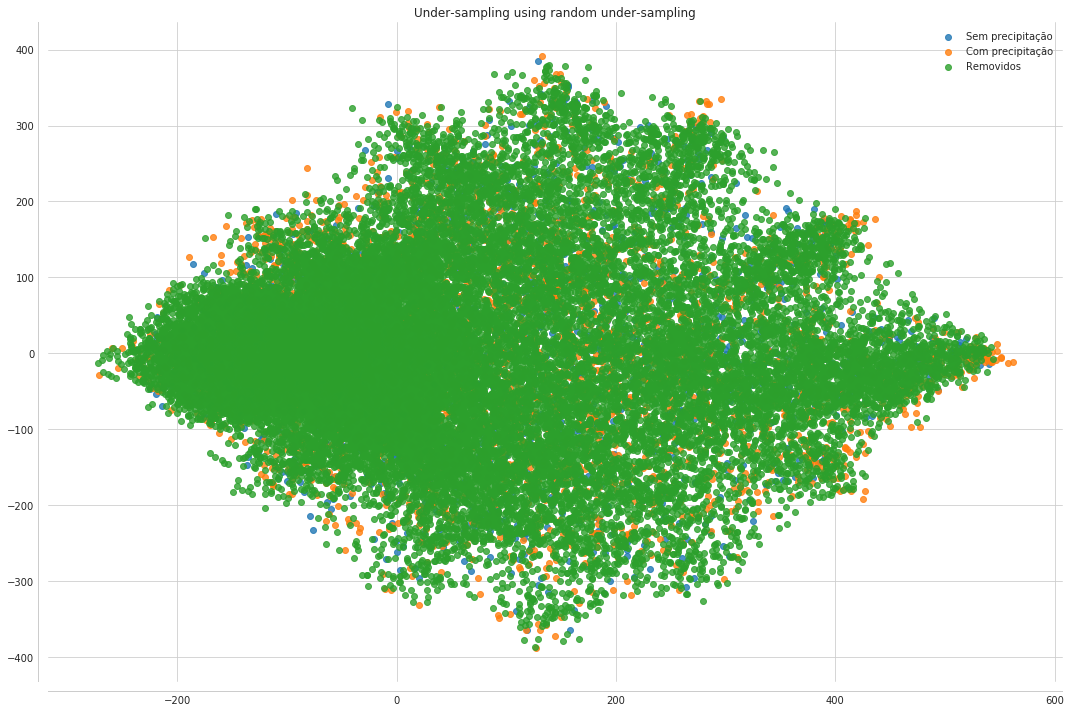

In [499]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
idx_samples_removed = np.setdiff1d(np.arange(X_vis.shape[0]),
                                   idx_resampled)

idx_class_0 = y_resampled == 0
plt.scatter(X_res_vis[idx_class_0, 0], X_res_vis[idx_class_0, 1],
            alpha=.8, label=u'Sem precipitação')
plt.scatter(X_res_vis[~idx_class_0, 0], X_res_vis[~idx_class_0, 1],
            alpha=.8, label=u'Com precipitação')
plt.scatter(X_vis[idx_samples_removed, 0], X_vis[idx_samples_removed, 1],
            alpha=.8, label='Removidos')

# make nice plotting
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
#ax.set_xlim([-6, 6])
#ax.set_ylim([-6, 6])

plt.title('Under-sampling using random under-sampling')
plt.legend()
plt.tight_layout()
plt.show()


In [375]:
#X_train_over, y_train_over =  SMOTE(random_state=12).fit_sample(X_train, y_train)

In [500]:
len(X_resampled), len(y_resampled)

(7988, 7988)

<p>Reconstruindo o dataframe</p>

In [501]:
#X_train = pd.DataFrame(X_train_over, columns = X_train.columns)
X_train = pd.DataFrame(X_resampled, columns = X_train.columns)

In [502]:
#y_train = pd.DataFrame(y_train_over, columns =['type'])
y_train = pd.DataFrame(y_resampled, columns =['type'])

In [503]:
X_train.head()

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,wdct_1,wdct_2,wdct_3,wdct_4,wdct_5,gust_1,gust_2,gust_3,gust_4,gust_5
0,0.0,926.0,926.0,925.3,20.6,10.5,21.8,10.5,20.4,9.8,...,87.0,92.0,80.0,71.0,85.0,8.3,7.6,9.3,9.3,6.8
1,0.0,925.1,925.1,924.7,14.3,11.3,14.6,11.4,14.3,11.3,...,97.0,113.0,107.0,112.0,107.0,5.4,5.9,5.8,5.9,5.8
2,0.0,921.2,921.3,921.0,19.6,14.8,20.5,15.0,19.6,14.7,...,135.0,124.0,130.0,127.0,122.0,10.8,9.4,9.4,6.3,4.5
3,0.0,920.4,920.4,920.2,17.4,11.6,17.5,11.8,17.2,11.6,...,106.0,87.0,117.0,91.0,96.0,4.0,4.0,4.0,5.4,5.8
4,0.0,914.7,915.8,914.7,27.4,16.2,27.8,17.7,25.6,15.0,...,318.0,300.0,115.0,74.0,96.0,4.1,3.6,4.0,4.9,6.0


In [504]:
#Como o balanceamento SMOTE não serve valores continuos, eu criei classes de chuvas, \
#mas o objetivo ainda persiste em prever o volume de precipitação. Assim vou colocar como alvo a precipitação

<p>Reconstruindo o datafram para alimnar o tensorflow</p>

In [505]:
y_train['prcp'] = X_train['prcp']
y_tmp = X_tmp['prcp']

In [506]:
y_train = y_train.drop('type',1)

In [507]:
X_train = X_train.drop('prcp',1)
X_tmp = X_tmp.drop('prcp',1)

In [508]:
X_tmp.head(3)

,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,hmdy,...,wdct_1,wdct_2,wdct_3,wdct_4,wdct_5,gust_1,gust_2,gust_3,gust_4,gust_5
65978,919.5,919.8,919.4,19.7,18.0,21.9,18.2,19.6,16.7,90.0,...,146.0,50.0,130.0,122.0,331.0,7.8,2.8,4.4,4.4,2.5
38040,915.7,915.7,915.1,25.7,17.3,26.4,17.5,25.7,17.0,60.0,...,79.0,97.0,81.0,69.0,108.0,5.6,8.4,9.4,8.9,10.0
68328,924.1,924.1,923.4,14.6,13.7,14.9,13.8,14.6,13.6,94.0,...,83.0,105.0,9.0,20.0,31.0,4.5,3.2,1.8,3.3,3.1


<p>Separando o conjunto de testes</p>

In [509]:
target = 'prcp'

In [510]:
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.5)

In [511]:
X_train.shape, X_test.shape, X_val.shape  
print("Training instances   {}, Training features   {}".format(X_train.shape[0], X_train.shape[1]))  
print("Validation instances {}, Validation features {}".format(X_val.shape[0], X_val.shape[1]))  
print("Testing instances    {}, Testing features    {}".format(X_test.shape[0], X_test.shape[1]))  

Training instances   7988, Training features   90
Validation instances 12902, Validation features 90
Testing instances    12901, Testing features    90


In [512]:
# Zarate instructions
st_units = (X_train.shape[1] * 2) + 1
sd_units = X_train.shape[1] 
#activation_fn = tf.sigmoid
batch_size = 500
up = int(len(X_train)/batch_size)

In [513]:
up

15

In [514]:
feature_cols = [tf.feature_column.numeric_column(col) for col in X_train.columns] 

In [516]:
regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols,  
                                      hidden_units=[st_units,sd_units],
                                     # activation_fn=activation_fn,
                                      model_dir='/tmp/tf_wx_model-16')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f91fe08ab50>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tf_wx_model-16', '_save_summary_steps': 100}


In [517]:
def wx_input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=batch_size):  
    return tf.estimator.inputs.pandas_input_fn(x=X,
                                               y=y,
                                               num_epochs=num_epochs,
                                               shuffle=shuffle,
                                               batch_size=batch_size)

In [518]:
evaluations = []  
STEPS = 500  
for i in range(1, 50):  
    regressor.train(input_fn=wx_input_fn(X_train, y=y_train), steps=STEPS)
    evaluations.append(regressor.evaluate(input_fn=wx_input_fn(X_val,
                                                               y_val,
                                                               num_epochs=1,
                                                               shuffle=False)))

/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Create CheckpointSaverHook.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Saving checkpoints for 1 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 54926824.0, step = 1
INFO:tensorflow:global_step/sec: 22.8174
INFO:tensorflow:loss = 11037.072, step = 101 (4.384 sec)
INFO:tensorflow:global_step/sec: 23.5196
INFO:tensorflow:loss = 14981.453, step = 201 (4.252 sec)
INFO:tensorflow:global_step/sec: 25.2223
INFO:tensorflow:loss = 11139.592, step = 301 (3.965 sec)
INFO:tensorflow:global_step/sec: 24.8675
INFO:tensorflow:loss = 2799.8408, step = 401 (4.021 sec)
INFO:tensorflow:Saving checkpoints for 500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 1695.7574.
INFO:tensorflow:Starting evaluation at 2018-02-17-02:42:07
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-500


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Finished evaluation at 2018-02-17-02:42:09
INFO:tensorflow:Saving dict for global step 500: average_loss = 7.156052, global_step = 500, loss = 3551.0532
INFO:tensorflow:Create CheckpointSaverHook.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-500
INFO:tensorflow:Saving checkpoints for 501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 16853.4, step = 501
INFO:tensorflow:global_step/sec: 25.1448
INFO:tensorflow:loss = 6847.164, step = 601 (3.979 sec)
INFO:tensorflow:global_step/sec: 23.886
INFO:tensorflow:loss = 1612.3263, step = 701 (4.187 sec)
INFO:tensorflow:global_step/sec: 25.9835
INFO:tensorflow:loss = 12811.035, step = 801 (3.849 sec)
INFO:tensorflow:global_step/sec: 26.3286
INFO:tensorflow:loss = 15271.68, step = 901 (3.798 sec)
INFO:tensorflow:Saving checkpoints for 1000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 1535.5227.
INFO:tensorflow:Starting evaluation at 2018-02-17-02:42:32
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-1000


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Finished evaluation at 2018-02-17-02:42:34
INFO:tensorflow:Saving dict for global step 1000: average_loss = 5.9165134, global_step = 1000, loss = 2935.956
INFO:tensorflow:Create CheckpointSaverHook.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-1000
INFO:tensorflow:Saving checkpoints for 1001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 13634.577, step = 1001
INFO:tensorflow:global_step/sec: 26.251
INFO:tensorflow:loss = 3583.4385, step = 1101 (3.811 sec)
INFO:tensorflow:global_step/sec: 26.6236
INFO:tensorflow:loss = 1436.3655, step = 1201 (3.757 sec)
INFO:tensorflow:global_step/sec: 27.3966
INFO:tensorflow:loss = 20730.568, step = 1301 (3.650 sec)
INFO:tensorflow:global_step/sec: 26.6517
INFO:tensorflow:loss = 20356.71, step = 1401 (3.752 sec)
INFO:tensorflow:Saving checkpoints for 1500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 4495.9253.
INFO:tensorflow:Starting evaluation at 2018-02-17-02:42:56
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-1500


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Finished evaluation at 2018-02-17-02:42:58
INFO:tensorflow:Saving dict for global step 1500: average_loss = 5.542726, global_step = 1500, loss = 2750.4712


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-1500
INFO:tensorflow:Saving checkpoints for 1501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 1295.7585, step = 1501
INFO:tensorflow:global_step/sec: 25.4037
INFO:tensorflow:loss = 1151.407, step = 1601 (3.938 sec)
INFO:tensorflow:global_step/sec: 25.8136
INFO:tensorflow:loss = 15363.894, step = 1701 (3.874 sec)
INFO:tensorflow:global_step/sec: 26.7171
INFO:tensorflow:loss = 15209.284, step = 1801 (3.743 sec)
INFO:tensorflow:global_step/sec: 26.0938
INFO:tensorflow:loss = 2093.701, step = 1901 (3.833 sec)
INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 1149.4102.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Starting evaluation at 2018-02-17-02:43:21
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-2000


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


INFO:tensorflow:Finished evaluation at 2018-02-17-02:43:22
INFO:tensorflow:Saving dict for global step 2000: average_loss = 5.3050203, global_step = 2000, loss = 2632.5144
INFO:tensorflow:Create CheckpointSaverHook.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-2000
INFO:tensorflow:Saving checkpoints for 2001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 15089.746, step = 2001
INFO:tensorflow:global_step/sec: 24.4035
INFO:tensorflow:loss = 5333.4116, step = 2101 (4.099 sec)
INFO:tensorflow:global_step/sec: 26.7223
INFO:tensorflow:loss = 1808.3208, step = 2201 (3.742 sec)
INFO:tensorflow:global_step/sec: 25.9769
INFO:tensorflow:loss = 11980.721, step = 2301 (3.850 sec)
INFO:tensorflow:global_step/sec: 26.9848
INFO:tensorflow:loss = 13207.562, step = 2401 (3.706 sec)
INFO:tensorflow:Saving checkpoints for 2500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 1897.7665.
INFO:tensorflow:Starting evaluation at 2018-02-17-02:43:45
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-2500


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Finished evaluation at 2018-02-17-02:43:46
INFO:tensorflow:Saving dict for global step 2500: average_loss = 5.1137815, global_step = 2500, loss = 2537.6157
INFO:tensorflow:Create CheckpointSaverHook.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-2500
INFO:tensorflow:Saving checkpoints for 2501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 1055.5566, step = 2501
INFO:tensorflow:global_step/sec: 25.3806
INFO:tensorflow:loss = 1246.7743, step = 2601 (3.942 sec)
INFO:tensorflow:global_step/sec: 26.8342
INFO:tensorflow:loss = 8260.863, step = 2701 (3.727 sec)
INFO:tensorflow:global_step/sec: 25.7963
INFO:tensorflow:loss = 14668.365, step = 2801 (3.877 sec)
INFO:tensorflow:global_step/sec: 27.2957
INFO:tensorflow:loss = 2322.663, step = 2901 (3.663 sec)
INFO:tensorflow:Saving checkpoints for 3000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 1019.99994.
INFO:tensorflow:Starting evaluation at 2018-02-17-02:44:09
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-3000


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Finished evaluation at 2018-02-17-02:44:10
INFO:tensorflow:Saving dict for global step 3000: average_loss = 5.0193706, global_step = 3000, loss = 2490.766
INFO:tensorflow:Create CheckpointSaverHook.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-3000
INFO:tensorflow:Saving checkpoints for 3001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 14146.035, step = 3001
INFO:tensorflow:global_step/sec: 26.1897
INFO:tensorflow:loss = 1378.1306, step = 3101 (3.820 sec)
INFO:tensorflow:global_step/sec: 26.2015
INFO:tensorflow:loss = 1011.3247, step = 3201 (3.816 sec)
INFO:tensorflow:global_step/sec: 27.5065
INFO:tensorflow:loss = 12679.536, step = 3301 (3.636 sec)
INFO:tensorflow:global_step/sec: 27.4844
INFO:tensorflow:loss = 10804.667, step = 3401 (3.638 sec)
INFO:tensorflow:Saving checkpoints for 3500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 2307.15.
INFO:tensorflow:Starting evaluation at 2018-02-17-02:44:32
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-3500


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Finished evaluation at 2018-02-17-02:44:34
INFO:tensorflow:Saving dict for global step 3500: average_loss = 4.9193993, global_step = 3500, loss = 2441.1572
INFO:tensorflow:Create CheckpointSaverHook.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-3500
INFO:tensorflow:Saving checkpoints for 3501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 14820.925, step = 3501
INFO:tensorflow:global_step/sec: 25.69
INFO:tensorflow:loss = 5395.1006, step = 3601 (3.894 sec)
INFO:tensorflow:global_step/sec: 26.7841
INFO:tensorflow:loss = 901.88416, step = 3701 (3.733 sec)
INFO:tensorflow:global_step/sec: 25.8349
INFO:tensorflow:loss = 9579.98, step = 3801 (3.871 sec)
INFO:tensorflow:global_step/sec: 26.1968
INFO:tensorflow:loss = 10006.459, step = 3901 (3.817 sec)
INFO:tensorflow:Saving checkpoints for 4000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 7808.253.
INFO:tensorflow:Starting evaluation at 2018-02-17-02:44:57
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-4000


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Finished evaluation at 2018-02-17-02:44:58
INFO:tensorflow:Saving dict for global step 4000: average_loss = 4.981167, global_step = 4000, loss = 2471.808
INFO:tensorflow:Create CheckpointSaverHook.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-4000
INFO:tensorflow:Saving checkpoints for 4001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 18072.768, step = 4001
INFO:tensorflow:global_step/sec: 24.5027
INFO:tensorflow:loss = 1568.422, step = 4101 (4.082 sec)
INFO:tensorflow:global_step/sec: 25.5013
INFO:tensorflow:loss = 3252.5557, step = 4201 (3.921 sec)
INFO:tensorflow:global_step/sec: 25.526
INFO:tensorflow:loss = 9136.017, step = 4301 (3.918 sec)
INFO:tensorflow:global_step/sec: 26.4006
INFO:tensorflow:loss = 10514.796, step = 4401 (3.789 sec)
INFO:tensorflow:Saving checkpoints for 4500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 2032.0569.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Starting evaluation at 2018-02-17-02:45:21
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-4500


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


INFO:tensorflow:Finished evaluation at 2018-02-17-02:45:23
INFO:tensorflow:Saving dict for global step 4500: average_loss = 4.773422, global_step = 4500, loss = 2368.7188


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-4500


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Saving checkpoints for 4501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 18419.879, step = 4501
INFO:tensorflow:global_step/sec: 24.5256
INFO:tensorflow:loss = 16627.094, step = 4601 (4.080 sec)
INFO:tensorflow:global_step/sec: 26.8514
INFO:tensorflow:loss = 4073.9858, step = 4701 (3.725 sec)
INFO:tensorflow:global_step/sec: 25.6372
INFO:tensorflow:loss = 866.92395, step = 4801 (3.900 sec)
INFO:tensorflow:global_step/sec: 25.8637
INFO:tensorflow:loss = 19156.703, step = 4901 (3.866 sec)
INFO:tensorflow:Saving checkpoints for 5000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 8897.109.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Starting evaluation at 2018-02-17-02:45:46
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-5000


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


INFO:tensorflow:Finished evaluation at 2018-02-17-02:45:47
INFO:tensorflow:Saving dict for global step 5000: average_loss = 5.1930404, global_step = 5000, loss = 2576.9465


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-5000


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Saving checkpoints for 5001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 15004.131, step = 5001
INFO:tensorflow:global_step/sec: 24.2814
INFO:tensorflow:loss = 6841.8906, step = 5101 (4.120 sec)
INFO:tensorflow:global_step/sec: 26.765
INFO:tensorflow:loss = 975.24097, step = 5201 (3.737 sec)
INFO:tensorflow:global_step/sec: 25.5862
INFO:tensorflow:loss = 9077.048, step = 5301 (3.908 sec)
INFO:tensorflow:global_step/sec: 26.5565
INFO:tensorflow:loss = 17122.793, step = 5401 (3.766 sec)
INFO:tensorflow:Saving checkpoints for 5500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 9693.518.
INFO:tensorflow:Starting evaluation at 2018-02-17-02:46:10
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-5500


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Finished evaluation at 2018-02-17-02:46:11
INFO:tensorflow:Saving dict for global step 5500: average_loss = 5.3797455, global_step = 5500, loss = 2669.5952
INFO:tensorflow:Create CheckpointSaverHook.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-5500
INFO:tensorflow:Saving checkpoints for 5501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 9056.203, step = 5501
INFO:tensorflow:global_step/sec: 25.6808
INFO:tensorflow:loss = 933.3723, step = 5601 (3.896 sec)
INFO:tensorflow:global_step/sec: 26.8411
INFO:tensorflow:loss = 4977.9883, step = 5701 (3.725 sec)
INFO:tensorflow:global_step/sec: 27.3052
INFO:tensorflow:loss = 13428.748, step = 5801 (3.662 sec)
INFO:tensorflow:global_step/sec: 27.3809
INFO:tensorflow:loss = 7876.3354, step = 5901 (3.652 sec)
INFO:tensorflow:Saving checkpoints for 6000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 854.8411.
INFO:tensorflow:Starting evaluation at 2018-02-17-02:46:34
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-6000


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Finished evaluation at 2018-02-17-02:46:35
INFO:tensorflow:Saving dict for global step 6000: average_loss = 4.6299324, global_step = 6000, loss = 2297.515
INFO:tensorflow:Create CheckpointSaverHook.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-6000
INFO:tensorflow:Saving checkpoints for 6001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 15624.016, step = 6001
INFO:tensorflow:global_step/sec: 25.8807
INFO:tensorflow:loss = 14790.881, step = 6101 (3.866 sec)
INFO:tensorflow:global_step/sec: 27.4435
INFO:tensorflow:loss = 1742.8074, step = 6201 (3.644 sec)
INFO:tensorflow:global_step/sec: 26.4586
INFO:tensorflow:loss = 2247.9712, step = 6301 (3.780 sec)
INFO:tensorflow:global_step/sec: 26.6846
INFO:tensorflow:loss = 10520.2, step = 6401 (3.747 sec)
INFO:tensorflow:Saving checkpoints for 6500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 13289.837.
INFO:tensorflow:Starting evaluation at 2018-02-17-02:46:58
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-6500


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Finished evaluation at 2018-02-17-02:46:59
INFO:tensorflow:Saving dict for global step 6500: average_loss = 6.0905323, global_step = 6500, loss = 3022.3096
INFO:tensorflow:Create CheckpointSaverHook.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-6500
INFO:tensorflow:Saving checkpoints for 6501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 14138.57, step = 6501
INFO:tensorflow:global_step/sec: 25.9073
INFO:tensorflow:loss = 1963.1316, step = 6601 (3.862 sec)
INFO:tensorflow:global_step/sec: 26.5737
INFO:tensorflow:loss = 1427.9038, step = 6701 (3.762 sec)
INFO:tensorflow:global_step/sec: 26.9747
INFO:tensorflow:loss = 15728.649, step = 6801 (3.707 sec)
INFO:tensorflow:global_step/sec: 25.3495
INFO:tensorflow:loss = 13983.306, step = 6901 (3.945 sec)
INFO:tensorflow:Saving checkpoints for 7000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 3842.62.
INFO:tensorflow:Starting evaluation at 2018-02-17-02:47:22
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-7000


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Finished evaluation at 2018-02-17-02:47:23
INFO:tensorflow:Saving dict for global step 7000: average_loss = 4.558102, global_step = 7000, loss = 2261.8706
INFO:tensorflow:Create CheckpointSaverHook.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-7000
INFO:tensorflow:Saving checkpoints for 7001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 10776.195, step = 7001
INFO:tensorflow:global_step/sec: 25.6959
INFO:tensorflow:loss = 6150.5615, step = 7101 (3.893 sec)
INFO:tensorflow:global_step/sec: 26.6246
INFO:tensorflow:loss = 947.39026, step = 7201 (3.756 sec)
INFO:tensorflow:global_step/sec: 24.5895
INFO:tensorflow:loss = 10629.577, step = 7301 (4.067 sec)
INFO:tensorflow:global_step/sec: 26.5325
INFO:tensorflow:loss = 15442.485, step = 7401 (3.768 sec)
INFO:tensorflow:Saving checkpoints for 7500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 3375.7847.
INFO:tensorflow:Starting evaluation at 2018-02-17-02:47:46
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-7500


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Finished evaluation at 2018-02-17-02:47:48
INFO:tensorflow:Saving dict for global step 7500: average_loss = 4.5485997, global_step = 7500, loss = 2257.155
INFO:tensorflow:Create CheckpointSaverHook.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-7500
INFO:tensorflow:Saving checkpoints for 7501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 927.7853, step = 7501
INFO:tensorflow:global_step/sec: 24.3401
INFO:tensorflow:loss = 861.86774, step = 7601 (4.110 sec)
INFO:tensorflow:global_step/sec: 25.9029
INFO:tensorflow:loss = 8457.621, step = 7701 (3.860 sec)
INFO:tensorflow:global_step/sec: 26.8209
INFO:tensorflow:loss = 17339.432, step = 7801 (3.728 sec)
INFO:tensorflow:global_step/sec: 25.8541
INFO:tensorflow:loss = 6138.108, step = 7901 (3.868 sec)
INFO:tensorflow:Saving checkpoints for 8000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 807.7715.
INFO:tensorflow:Starting evaluation at 2018-02-17-02:48:11
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-8000


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Finished evaluation at 2018-02-17-02:48:12
INFO:tensorflow:Saving dict for global step 8000: average_loss = 4.50095, global_step = 8000, loss = 2233.5098
INFO:tensorflow:Create CheckpointSaverHook.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-8000
INFO:tensorflow:Saving checkpoints for 8001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 5323.1675, step = 8001
INFO:tensorflow:global_step/sec: 25.6489
INFO:tensorflow:loss = 9455.011, step = 8101 (3.900 sec)
INFO:tensorflow:global_step/sec: 25.1061
INFO:tensorflow:loss = 8282.639, step = 8201 (3.983 sec)
INFO:tensorflow:global_step/sec: 27.6779
INFO:tensorflow:loss = 915.36346, step = 8301 (3.613 sec)
INFO:tensorflow:global_step/sec: 27.1502
INFO:tensorflow:loss = 12029.831, step = 8401 (3.683 sec)
INFO:tensorflow:Saving checkpoints for 8500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 10696.029.
INFO:tensorflow:Starting evaluation at 2018-02-17-02:48:34


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-8500
INFO:tensorflow:Finished evaluation at 2018-02-17-02:48:36
INFO:tensorflow:Saving dict for global step 8500: average_loss = 6.05266, global_step = 8500, loss = 3003.516
INFO:tensorflow:Create CheckpointSaverHook.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-8500
INFO:tensorflow:Saving checkpoints for 8501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 16599.484, step = 8501
INFO:tensorflow:global_step/sec: 26.1261
INFO:tensorflow:loss = 1431.3916, step = 8601 (3.830 sec)
INFO:tensorflow:global_step/sec: 26.9008
INFO:tensorflow:loss = 680.04114, step = 8701 (3.717 sec)
INFO:tensorflow:global_step/sec: 27.2845
INFO:tensorflow:loss = 12310.739, step = 8801 (3.665 sec)
INFO:tensorflow:global_step/sec: 27.054
INFO:tensorflow:loss = 10322.328, step = 8901 (3.696 sec)
INFO:tensorflow:Saving checkpoints for 9000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 1032.3333.
INFO:tensorflow:Starting evaluation at 2018-02-17-02:48:58


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-9000
INFO:tensorflow:Finished evaluation at 2018-02-17-02:49:00
INFO:tensorflow:Saving dict for global step 9000: average_loss = 4.415871, global_step = 9000, loss = 2191.2913


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-9000
INFO:tensorflow:Saving checkpoints for 9001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 9519.536, step = 9001
INFO:tensorflow:global_step/sec: 25.4146
INFO:tensorflow:loss = 1905.4369, step = 9101 (3.936 sec)
INFO:tensorflow:global_step/sec: 26.6022
INFO:tensorflow:loss = 5133.0986, step = 9201 (3.759 sec)
INFO:tensorflow:global_step/sec: 26.4129
INFO:tensorflow:loss = 10090.615, step = 9301 (3.786 sec)
INFO:tensorflow:global_step/sec: 26.1578
INFO:tensorflow:loss = 6303.8774, step = 9401 (3.824 sec)
INFO:tensorflow:Saving checkpoints for 9500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 2708.4858.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Starting evaluation at 2018-02-17-02:49:23
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-9500


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


INFO:tensorflow:Finished evaluation at 2018-02-17-02:49:24
INFO:tensorflow:Saving dict for global step 9500: average_loss = 4.387959, global_step = 9500, loss = 2177.4402


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-9500


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Saving checkpoints for 9501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 895.72046, step = 9501
INFO:tensorflow:global_step/sec: 25.3753
INFO:tensorflow:loss = 1307.3855, step = 9601 (3.942 sec)
INFO:tensorflow:global_step/sec: 25.8433
INFO:tensorflow:loss = 8971.424, step = 9701 (3.870 sec)
INFO:tensorflow:global_step/sec: 26.1135
INFO:tensorflow:loss = 14608.543, step = 9801 (3.829 sec)
INFO:tensorflow:global_step/sec: 27.4932
INFO:tensorflow:loss = 1351.0239, step = 9901 (3.641 sec)
INFO:tensorflow:Saving checkpoints for 10000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 969.0262.
INFO:tensorflow:Starting evaluation at 2018-02-17-02:49:46
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-10000


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Finished evaluation at 2018-02-17-02:49:48
INFO:tensorflow:Saving dict for global step 10000: average_loss = 4.3652716, global_step = 10000, loss = 2166.1821
INFO:tensorflow:Create CheckpointSaverHook.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-10000
INFO:tensorflow:Saving checkpoints for 10001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 6444.963, step = 10001
INFO:tensorflow:global_step/sec: 25.0468
INFO:tensorflow:loss = 13407.322, step = 10101 (3.994 sec)
INFO:tensorflow:global_step/sec: 26.0085
INFO:tensorflow:loss = 5914.875, step = 10201 (3.845 sec)
INFO:tensorflow:global_step/sec: 25.8908
INFO:tensorflow:loss = 928.676, step = 10301 (3.863 sec)
INFO:tensorflow:global_step/sec: 27.2483
INFO:tensorflow:loss = 10948.926, step = 10401 (3.669 sec)
INFO:tensorflow:Saving checkpoints for 10500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 10378.502.
INFO:tensorflow:Starting evaluation at 2018-02-17-02:50:10
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-10500


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Finished evaluation at 2018-02-17-02:50:12
INFO:tensorflow:Saving dict for global step 10500: average_loss = 5.4279604, global_step = 10500, loss = 2693.521
INFO:tensorflow:Create CheckpointSaverHook.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-10500
INFO:tensorflow:Saving checkpoints for 10501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 1238.1553, step = 10501
INFO:tensorflow:global_step/sec: 25.9008
INFO:tensorflow:loss = 1918.198, step = 10601 (3.863 sec)
INFO:tensorflow:global_step/sec: 27.5529
INFO:tensorflow:loss = 11102.322, step = 10701 (3.629 sec)
INFO:tensorflow:global_step/sec: 26.4782
INFO:tensorflow:loss = 10716.445, step = 10801 (3.777 sec)
INFO:tensorflow:global_step/sec: 26.7169
INFO:tensorflow:loss = 842.58057, step = 10901 (3.743 sec)
INFO:tensorflow:Saving checkpoints for 11000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 752.57.
INFO:tensorflow:Starting evaluation at 2018-02-17-02:50:34
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-11000


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Finished evaluation at 2018-02-17-02:50:36
INFO:tensorflow:Saving dict for global step 11000: average_loss = 4.331033, global_step = 11000, loss = 2149.192
INFO:tensorflow:Create CheckpointSaverHook.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-11000
INFO:tensorflow:Saving checkpoints for 11001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 15894.84, step = 11001
INFO:tensorflow:global_step/sec: 25.2216
INFO:tensorflow:loss = 10601.423, step = 11101 (3.966 sec)
INFO:tensorflow:global_step/sec: 25.5194
INFO:tensorflow:loss = 2743.445, step = 11201 (3.919 sec)
INFO:tensorflow:global_step/sec: 26.4396
INFO:tensorflow:loss = 670.1626, step = 11301 (3.783 sec)
INFO:tensorflow:global_step/sec: 26.5002
INFO:tensorflow:loss = 13275.09, step = 11401 (3.773 sec)
INFO:tensorflow:Saving checkpoints for 11500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 16789.742.
INFO:tensorflow:Starting evaluation at 2018-02-17-02:50:59
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-11500


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Finished evaluation at 2018-02-17-02:51:00
INFO:tensorflow:Saving dict for global step 11500: average_loss = 5.927065, global_step = 11500, loss = 2941.192
INFO:tensorflow:Create CheckpointSaverHook.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-11500
INFO:tensorflow:Saving checkpoints for 11501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 1580.5851, step = 11501
INFO:tensorflow:global_step/sec: 25.4153
INFO:tensorflow:loss = 6113.2773, step = 11601 (3.936 sec)
INFO:tensorflow:global_step/sec: 25.2514
INFO:tensorflow:loss = 15070.278, step = 11701 (3.960 sec)
INFO:tensorflow:global_step/sec: 26.3794
INFO:tensorflow:loss = 7018.3613, step = 11801 (3.791 sec)
INFO:tensorflow:global_step/sec: 26.9599
INFO:tensorflow:loss = 843.1466, step = 11901 (3.709 sec)
INFO:tensorflow:Saving checkpoints for 12000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 3640.314.
INFO:tensorflow:Starting evaluation at 2018-02-17-02:51:23


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-12000
INFO:tensorflow:Finished evaluation at 2018-02-17-02:51:24
INFO:tensorflow:Saving dict for global step 12000: average_loss = 4.2984204, global_step = 12000, loss = 2133.0085


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-12000
INFO:tensorflow:Saving checkpoints for 12001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 11682.633, step = 12001
INFO:tensorflow:global_step/sec: 24.8672
INFO:tensorflow:loss = 10829.535, step = 12101 (4.023 sec)
INFO:tensorflow:global_step/sec: 26.6516
INFO:tensorflow:loss = 5625.081, step = 12201 (3.752 sec)
INFO:tensorflow:global_step/sec: 26.6354
INFO:tensorflow:loss = 809.9103, step = 12301 (3.754 sec)
INFO:tensorflow:global_step/sec: 26.235
INFO:tensorflow:loss = 10600.737, step = 12401 (3.822 sec)
INFO:tensorflow:Saving checkpoints for 12500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 11461.054.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Starting evaluation at 2018-02-17-02:51:47
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-12500
INFO:tensorflow:Finished evaluation at 2018-02-17-02:51:49
INFO:tensorflow:Saving dict for global step 12500: average_loss = 5.286235, global_step = 12500, loss = 2623.1924


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-12500


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Saving checkpoints for 12501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 1354.2156, step = 12501
INFO:tensorflow:global_step/sec: 25.6769
INFO:tensorflow:loss = 12762.92, step = 12601 (3.896 sec)
INFO:tensorflow:global_step/sec: 27.0429
INFO:tensorflow:loss = 13591.789, step = 12701 (3.698 sec)
INFO:tensorflow:global_step/sec: 27.4517
INFO:tensorflow:loss = 3745.1948, step = 12801 (3.643 sec)
INFO:tensorflow:global_step/sec: 26.6487
INFO:tensorflow:loss = 743.8175, step = 12901 (3.752 sec)
INFO:tensorflow:Saving checkpoints for 13000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 14573.392.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Starting evaluation at 2018-02-17-02:52:11
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-13000


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


INFO:tensorflow:Finished evaluation at 2018-02-17-02:52:12
INFO:tensorflow:Saving dict for global step 13000: average_loss = 5.0210104, global_step = 13000, loss = 2491.5798


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-13000


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Saving checkpoints for 13001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 15007.004, step = 13001
INFO:tensorflow:global_step/sec: 26.2935
INFO:tensorflow:loss = 11705.193, step = 13101 (3.806 sec)
INFO:tensorflow:global_step/sec: 26.5185
INFO:tensorflow:loss = 3870.3765, step = 13201 (3.771 sec)
INFO:tensorflow:global_step/sec: 25.3528
INFO:tensorflow:loss = 728.1181, step = 13301 (3.944 sec)
INFO:tensorflow:global_step/sec: 26.9073
INFO:tensorflow:loss = 8902.951, step = 13401 (3.717 sec)
INFO:tensorflow:Saving checkpoints for 13500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 8686.86.
INFO:tensorflow:Starting evaluation at 2018-02-17-02:52:35
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-13500


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Finished evaluation at 2018-02-17-02:52:36
INFO:tensorflow:Saving dict for global step 13500: average_loss = 5.068029, global_step = 13500, loss = 2514.9119
INFO:tensorflow:Create CheckpointSaverHook.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-13500
INFO:tensorflow:Saving checkpoints for 13501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 13732.427, step = 13501
INFO:tensorflow:global_step/sec: 25.3907
INFO:tensorflow:loss = 1887.4194, step = 13601 (3.940 sec)
INFO:tensorflow:global_step/sec: 24.9217
INFO:tensorflow:loss = 2781.4912, step = 13701 (4.013 sec)
INFO:tensorflow:global_step/sec: 26.2629
INFO:tensorflow:loss = 12378.927, step = 13801 (3.812 sec)
INFO:tensorflow:global_step/sec: 26.3192
INFO:tensorflow:loss = 6031.6875, step = 13901 (3.795 sec)
INFO:tensorflow:Saving checkpoints for 14000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 2643.1675.
INFO:tensorflow:Starting evaluation at 2018-02-17-02:52:59
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-14000


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Finished evaluation at 2018-02-17-02:53:01
INFO:tensorflow:Saving dict for global step 14000: average_loss = 4.20217, global_step = 14000, loss = 2085.246
INFO:tensorflow:Create CheckpointSaverHook.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-14000
INFO:tensorflow:Saving checkpoints for 14001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 649.3242, step = 14001
INFO:tensorflow:global_step/sec: 25.3118
INFO:tensorflow:loss = 3235.904, step = 14101 (3.953 sec)
INFO:tensorflow:global_step/sec: 27.909
INFO:tensorflow:loss = 15610.728, step = 14201 (3.583 sec)
INFO:tensorflow:global_step/sec: 27.1707
INFO:tensorflow:loss = 11419.5625, step = 14301 (3.682 sec)
INFO:tensorflow:global_step/sec: 26.7465
INFO:tensorflow:loss = 779.35095, step = 14401 (3.740 sec)
INFO:tensorflow:Saving checkpoints for 14500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 640.56226.
INFO:tensorflow:Starting evaluation at 2018-02-17-02:53:23
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-14500


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Finished evaluation at 2018-02-17-02:53:24
INFO:tensorflow:Saving dict for global step 14500: average_loss = 4.1910734, global_step = 14500, loss = 2079.7395
INFO:tensorflow:Create CheckpointSaverHook.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-14500
INFO:tensorflow:Saving checkpoints for 14501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 561.049, step = 14501
INFO:tensorflow:global_step/sec: 25.6364
INFO:tensorflow:loss = 12464.315, step = 14601 (3.902 sec)
INFO:tensorflow:global_step/sec: 25.5387
INFO:tensorflow:loss = 12662.975, step = 14701 (3.916 sec)
INFO:tensorflow:global_step/sec: 26.0489
INFO:tensorflow:loss = 736.45135, step = 14801 (3.839 sec)
INFO:tensorflow:global_step/sec: 26.819
INFO:tensorflow:loss = 1009.81915, step = 14901 (3.728 sec)
INFO:tensorflow:Saving checkpoints for 15000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 14648.031.
INFO:tensorflow:Starting evaluation at 2018-02-17-02:53:47
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-15000


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Finished evaluation at 2018-02-17-02:53:49
INFO:tensorflow:Saving dict for global step 15000: average_loss = 5.6092043, global_step = 15000, loss = 2783.4597
INFO:tensorflow:Create CheckpointSaverHook.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-15000
INFO:tensorflow:Saving checkpoints for 15001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 1609.1372, step = 15001
INFO:tensorflow:global_step/sec: 25.8769
INFO:tensorflow:loss = 14850.428, step = 15101 (3.866 sec)
INFO:tensorflow:global_step/sec: 27.4241
INFO:tensorflow:loss = 10805.99, step = 15201 (3.649 sec)
INFO:tensorflow:global_step/sec: 26.3908
INFO:tensorflow:loss = 4161.2627, step = 15301 (3.787 sec)
INFO:tensorflow:global_step/sec: 26.6679
INFO:tensorflow:loss = 649.7003, step = 15401 (3.749 sec)
INFO:tensorflow:Saving checkpoints for 15500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 10317.743.
INFO:tensorflow:Starting evaluation at 2018-02-17-02:54:11
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-15500


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Finished evaluation at 2018-02-17-02:54:13
INFO:tensorflow:Saving dict for global step 15500: average_loss = 4.628647, global_step = 15500, loss = 2296.877
INFO:tensorflow:Create CheckpointSaverHook.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-15500
INFO:tensorflow:Saving checkpoints for 15501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 3004.0425, step = 15501
INFO:tensorflow:global_step/sec: 25.0578
INFO:tensorflow:loss = 14412.25, step = 15601 (3.993 sec)
INFO:tensorflow:global_step/sec: 26.6738
INFO:tensorflow:loss = 8147.949, step = 15701 (3.749 sec)
INFO:tensorflow:global_step/sec: 26.9515
INFO:tensorflow:loss = 1206.9834, step = 15801 (3.710 sec)
INFO:tensorflow:global_step/sec: 26.6243
INFO:tensorflow:loss = 6905.905, step = 15901 (3.756 sec)
INFO:tensorflow:Saving checkpoints for 16000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 13943.953.
INFO:tensorflow:Starting evaluation at 2018-02-17-02:54:35


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-16000
INFO:tensorflow:Finished evaluation at 2018-02-17-02:54:37
INFO:tensorflow:Saving dict for global step 16000: average_loss = 5.9861207, global_step = 16000, loss = 2970.4973


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-16000
INFO:tensorflow:Saving checkpoints for 16001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 2657.6506, step = 16001
INFO:tensorflow:global_step/sec: 25.2484
INFO:tensorflow:loss = 2132.8223, step = 16101 (3.963 sec)
INFO:tensorflow:global_step/sec: 25.5684
INFO:tensorflow:loss = 10656.172, step = 16201 (3.911 sec)
INFO:tensorflow:global_step/sec: 25.3123
INFO:tensorflow:loss = 9804.131, step = 16301 (3.951 sec)
INFO:tensorflow:global_step/sec: 26.1751
INFO:tensorflow:loss = 5689.777, step = 16401 (3.821 sec)
INFO:tensorflow:Saving checkpoints for 16500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 1349.9929.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Starting evaluation at 2018-02-17-02:55:00
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-16500
INFO:tensorflow:Finished evaluation at 2018-02-17-02:55:01
INFO:tensorflow:Saving dict for global step 16500: average_loss = 4.123777, global_step = 16500, loss = 2046.345


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-16500


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Saving checkpoints for 16501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 17594.717, step = 16501
INFO:tensorflow:global_step/sec: 25.5144
INFO:tensorflow:loss = 14652.146, step = 16601 (3.921 sec)
INFO:tensorflow:global_step/sec: 26.2128
INFO:tensorflow:loss = 2669.701, step = 16701 (3.815 sec)
INFO:tensorflow:global_step/sec: 26.4818
INFO:tensorflow:loss = 602.1053, step = 16801 (3.776 sec)
INFO:tensorflow:global_step/sec: 25.8012
INFO:tensorflow:loss = 15184.452, step = 16901 (3.876 sec)
INFO:tensorflow:Saving checkpoints for 17000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 15466.762.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Starting evaluation at 2018-02-17-02:55:24
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-17000


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


INFO:tensorflow:Finished evaluation at 2018-02-17-02:55:25
INFO:tensorflow:Saving dict for global step 17000: average_loss = 5.8915467, global_step = 17000, loss = 2923.5667


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-17000


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Saving checkpoints for 17001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 11257.162, step = 17001
INFO:tensorflow:global_step/sec: 23.6922
INFO:tensorflow:loss = 939.4785, step = 17101 (4.223 sec)
INFO:tensorflow:global_step/sec: 26.615
INFO:tensorflow:loss = 636.7751, step = 17201 (3.758 sec)
INFO:tensorflow:global_step/sec: 26.4348
INFO:tensorflow:loss = 17366.484, step = 17301 (3.783 sec)
INFO:tensorflow:global_step/sec: 25.4173
INFO:tensorflow:loss = 12580.258, step = 17401 (3.935 sec)
INFO:tensorflow:Saving checkpoints for 17500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 3641.0312.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Starting evaluation at 2018-02-17-02:55:49
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-17500


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


INFO:tensorflow:Finished evaluation at 2018-02-17-02:55:50
INFO:tensorflow:Saving dict for global step 17500: average_loss = 4.1370153, global_step = 17500, loss = 2052.9143


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-17500


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Saving checkpoints for 17501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 15454.752, step = 17501
INFO:tensorflow:global_step/sec: 25.2332
INFO:tensorflow:loss = 1928.5703, step = 17601 (3.965 sec)
INFO:tensorflow:global_step/sec: 27.0121
INFO:tensorflow:loss = 762.8186, step = 17701 (3.702 sec)
INFO:tensorflow:global_step/sec: 24.7903
INFO:tensorflow:loss = 11556.248, step = 17801 (4.036 sec)
INFO:tensorflow:global_step/sec: 26.1564
INFO:tensorflow:loss = 9495.979, step = 17901 (3.821 sec)
INFO:tensorflow:Saving checkpoints for 18000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 1744.1891.
INFO:tensorflow:Starting evaluation at 2018-02-17-02:56:13
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-18000


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Finished evaluation at 2018-02-17-02:56:14
INFO:tensorflow:Saving dict for global step 18000: average_loss = 4.098739, global_step = 18000, loss = 2033.9204
INFO:tensorflow:Create CheckpointSaverHook.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-18000
INFO:tensorflow:Saving checkpoints for 18001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 703.0034, step = 18001
INFO:tensorflow:global_step/sec: 25.6125
INFO:tensorflow:loss = 15463.06, step = 18101 (3.906 sec)
INFO:tensorflow:global_step/sec: 26.7176
INFO:tensorflow:loss = 9571.724, step = 18201 (3.743 sec)
INFO:tensorflow:global_step/sec: 25.6685
INFO:tensorflow:loss = 3332.3635, step = 18301 (3.896 sec)
INFO:tensorflow:global_step/sec: 26.4297
INFO:tensorflow:loss = 642.58466, step = 18401 (3.784 sec)
INFO:tensorflow:Saving checkpoints for 18500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 7821.5996.
INFO:tensorflow:Starting evaluation at 2018-02-17-02:56:37
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-18500


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Finished evaluation at 2018-02-17-02:56:38
INFO:tensorflow:Saving dict for global step 18500: average_loss = 4.739987, global_step = 18500, loss = 2352.1274
INFO:tensorflow:Create CheckpointSaverHook.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-18500
INFO:tensorflow:Saving checkpoints for 18501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 934.1096, step = 18501
INFO:tensorflow:global_step/sec: 26.2529
INFO:tensorflow:loss = 4798.6025, step = 18601 (3.811 sec)
INFO:tensorflow:global_step/sec: 27.5317
INFO:tensorflow:loss = 15407.979, step = 18701 (3.633 sec)
INFO:tensorflow:global_step/sec: 27.4028
INFO:tensorflow:loss = 10696.572, step = 18801 (3.649 sec)
INFO:tensorflow:global_step/sec: 26.4758
INFO:tensorflow:loss = 694.04297, step = 18901 (3.777 sec)
INFO:tensorflow:Saving checkpoints for 19000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 608.5002.
INFO:tensorflow:Starting evaluation at 2018-02-17-02:57:01
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-19000


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Finished evaluation at 2018-02-17-02:57:02
INFO:tensorflow:Saving dict for global step 19000: average_loss = 4.0798554, global_step = 19000, loss = 2024.5497
INFO:tensorflow:Create CheckpointSaverHook.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-19000
INFO:tensorflow:Saving checkpoints for 19001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 12000.551, step = 19001
INFO:tensorflow:global_step/sec: 26.3559
INFO:tensorflow:loss = 8373.791, step = 19101 (3.796 sec)
INFO:tensorflow:global_step/sec: 27.6332
INFO:tensorflow:loss = 632.79614, step = 19201 (3.619 sec)
INFO:tensorflow:global_step/sec: 27.0078
INFO:tensorflow:loss = 9046.646, step = 19301 (3.703 sec)
INFO:tensorflow:global_step/sec: 27.5112
INFO:tensorflow:loss = 10970.606, step = 19401 (3.634 sec)
INFO:tensorflow:Saving checkpoints for 19500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 7367.286.
INFO:tensorflow:Starting evaluation at 2018-02-17-02:57:24
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-19500


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Finished evaluation at 2018-02-17-02:57:25
INFO:tensorflow:Saving dict for global step 19500: average_loss = 4.3966656, global_step = 19500, loss = 2181.7607
INFO:tensorflow:Create CheckpointSaverHook.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-19500
INFO:tensorflow:Saving checkpoints for 19501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 2912.0342, step = 19501
INFO:tensorflow:global_step/sec: 25.2678
INFO:tensorflow:loss = 1280.3269, step = 19601 (3.959 sec)
INFO:tensorflow:global_step/sec: 25.82
INFO:tensorflow:loss = 12756.613, step = 19701 (3.873 sec)
INFO:tensorflow:global_step/sec: 25.8358
INFO:tensorflow:loss = 10679.179, step = 19801 (3.870 sec)
INFO:tensorflow:global_step/sec: 26.2324
INFO:tensorflow:loss = 3027.6719, step = 19901 (3.812 sec)
INFO:tensorflow:Saving checkpoints for 20000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 702.23096.
INFO:tensorflow:Starting evaluation at 2018-02-17-02:57:48


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-20000
INFO:tensorflow:Finished evaluation at 2018-02-17-02:57:50
INFO:tensorflow:Saving dict for global step 20000: average_loss = 4.0612135, global_step = 20000, loss = 2015.2991
INFO:tensorflow:Create CheckpointSaverHook.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-20000
INFO:tensorflow:Saving checkpoints for 20001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 670.96906, step = 20001
INFO:tensorflow:global_step/sec: 25.8248
INFO:tensorflow:loss = 719.54785, step = 20101 (3.874 sec)
INFO:tensorflow:global_step/sec: 27.4344
INFO:tensorflow:loss = 11465.242, step = 20201 (3.645 sec)
INFO:tensorflow:global_step/sec: 26.9199
INFO:tensorflow:loss = 17443.707, step = 20301 (3.715 sec)
INFO:tensorflow:global_step/sec: 27.2566
INFO:tensorflow:loss = 2871.6343, step = 20401 (3.669 sec)
INFO:tensorflow:Saving checkpoints for 20500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 696.9433.
INFO:tensorflow:Starting evaluation at 2018-02-17-02:58:12


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-20500
INFO:tensorflow:Finished evaluation at 2018-02-17-02:58:14
INFO:tensorflow:Saving dict for global step 20500: average_loss = 4.057641, global_step = 20500, loss = 2013.5265


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-20500
INFO:tensorflow:Saving checkpoints for 20501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 14890.371, step = 20501
INFO:tensorflow:global_step/sec: 26.9224
INFO:tensorflow:loss = 11461.855, step = 20601 (3.716 sec)
INFO:tensorflow:global_step/sec: 27.8327
INFO:tensorflow:loss = 1068.97, step = 20701 (3.597 sec)
INFO:tensorflow:global_step/sec: 27.9194
INFO:tensorflow:loss = 9278.022, step = 20801 (3.578 sec)
INFO:tensorflow:global_step/sec: 27.4986
INFO:tensorflow:loss = 7744.661, step = 20901 (3.636 sec)
INFO:tensorflow:Saving checkpoints for 21000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 10401.229.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Starting evaluation at 2018-02-17-02:58:36
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-21000
INFO:tensorflow:Finished evaluation at 2018-02-17-02:58:37
INFO:tensorflow:Saving dict for global step 21000: average_loss = 4.9413695, global_step = 21000, loss = 2452.0596


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-21000


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Saving checkpoints for 21001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 1224.5939, step = 21001
INFO:tensorflow:global_step/sec: 25.1438
INFO:tensorflow:loss = 12532.734, step = 21101 (3.979 sec)
INFO:tensorflow:global_step/sec: 26.7974
INFO:tensorflow:loss = 11669.928, step = 21201 (3.737 sec)
INFO:tensorflow:global_step/sec: 27.1852
INFO:tensorflow:loss = 2490.3547, step = 21301 (3.674 sec)
INFO:tensorflow:global_step/sec: 26.2851
INFO:tensorflow:loss = 626.4928, step = 21401 (3.804 sec)
INFO:tensorflow:Saving checkpoints for 21500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 8373.668.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Starting evaluation at 2018-02-17-02:58:59
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-21500


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


INFO:tensorflow:Finished evaluation at 2018-02-17-02:59:01
INFO:tensorflow:Saving dict for global step 21500: average_loss = 4.6479793, global_step = 21500, loss = 2306.4702


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-21500


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Saving checkpoints for 21501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 1061.7113, step = 21501
INFO:tensorflow:global_step/sec: 25.7232
INFO:tensorflow:loss = 589.8124, step = 21601 (3.889 sec)
INFO:tensorflow:global_step/sec: 26.5697
INFO:tensorflow:loss = 15690.086, step = 21701 (3.763 sec)
INFO:tensorflow:global_step/sec: 26.8378
INFO:tensorflow:loss = 11813.759, step = 21801 (3.726 sec)
INFO:tensorflow:global_step/sec: 26.0508
INFO:tensorflow:loss = 2462.24, step = 21901 (3.839 sec)
INFO:tensorflow:Saving checkpoints for 22000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 645.3242.
INFO:tensorflow:Starting evaluation at 2018-02-17-02:59:23
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-22000


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Finished evaluation at 2018-02-17-02:59:25
INFO:tensorflow:Saving dict for global step 22000: average_loss = 4.0309677, global_step = 22000, loss = 2000.2902
INFO:tensorflow:Create CheckpointSaverHook.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-22000
INFO:tensorflow:Saving checkpoints for 22001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 550.0935, step = 22001
INFO:tensorflow:global_step/sec: 25.4618
INFO:tensorflow:loss = 3989.5527, step = 22101 (3.929 sec)
INFO:tensorflow:global_step/sec: 26.7249
INFO:tensorflow:loss = 8437.977, step = 22201 (3.742 sec)
INFO:tensorflow:global_step/sec: 25.6639
INFO:tensorflow:loss = 10137.169, step = 22301 (3.897 sec)
INFO:tensorflow:global_step/sec: 26.5894
INFO:tensorflow:loss = 1315.3304, step = 22401 (3.761 sec)
INFO:tensorflow:Saving checkpoints for 22500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 1176.5171.
INFO:tensorflow:Starting evaluation at 2018-02-17-02:59:47
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-22500


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Finished evaluation at 2018-02-17-02:59:49
INFO:tensorflow:Saving dict for global step 22500: average_loss = 4.001366, global_step = 22500, loss = 1985.6011
INFO:tensorflow:Create CheckpointSaverHook.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-22500
INFO:tensorflow:Saving checkpoints for 22501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 16142.48, step = 22501
INFO:tensorflow:global_step/sec: 25.5871
INFO:tensorflow:loss = 12057.159, step = 22601 (3.910 sec)
INFO:tensorflow:global_step/sec: 25.5271
INFO:tensorflow:loss = 2825.358, step = 22701 (3.918 sec)
INFO:tensorflow:global_step/sec: 25.0658
INFO:tensorflow:loss = 579.7456, step = 22801 (3.988 sec)
INFO:tensorflow:global_step/sec: 25.657
INFO:tensorflow:loss = 16074.618, step = 22901 (3.897 sec)
INFO:tensorflow:Saving checkpoints for 23000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 14857.135.
INFO:tensorflow:Starting evaluation at 2018-02-17-03:00:12
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-23000


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Finished evaluation at 2018-02-17-03:00:13
INFO:tensorflow:Saving dict for global step 23000: average_loss = 5.521871, global_step = 23000, loss = 2740.1223
INFO:tensorflow:Create CheckpointSaverHook.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-23000
INFO:tensorflow:Saving checkpoints for 23001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 9187.961, step = 23001
INFO:tensorflow:global_step/sec: 25.4793
INFO:tensorflow:loss = 9278.088, step = 23101 (3.926 sec)
INFO:tensorflow:global_step/sec: 25.8506
INFO:tensorflow:loss = 2934.3784, step = 23201 (3.869 sec)
INFO:tensorflow:global_step/sec: 26.7278
INFO:tensorflow:loss = 2518.6196, step = 23301 (3.741 sec)
INFO:tensorflow:global_step/sec: 25.668
INFO:tensorflow:loss = 10698.435, step = 23401 (3.898 sec)
INFO:tensorflow:Saving checkpoints for 23500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 9050.574.
INFO:tensorflow:Starting evaluation at 2018-02-17-03:00:36
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-23500


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Finished evaluation at 2018-02-17-03:00:38
INFO:tensorflow:Saving dict for global step 23500: average_loss = 5.217137, global_step = 23500, loss = 2588.9038
INFO:tensorflow:Create CheckpointSaverHook.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-23500
INFO:tensorflow:Saving checkpoints for 23501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 10184.565, step = 23501
INFO:tensorflow:global_step/sec: 26.1868
INFO:tensorflow:loss = 2213.4067, step = 23601 (3.821 sec)
INFO:tensorflow:global_step/sec: 25.8531
INFO:tensorflow:loss = 563.01855, step = 23701 (3.868 sec)
INFO:tensorflow:global_step/sec: 26.1426
INFO:tensorflow:loss = 14264.619, step = 23801 (3.825 sec)
INFO:tensorflow:global_step/sec: 26.2035
INFO:tensorflow:loss = 9900.305, step = 23901 (3.816 sec)
INFO:tensorflow:Saving checkpoints for 24000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 2019.1608.
INFO:tensorflow:Starting evaluation at 2018-02-17-03:01:01
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-24000


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Finished evaluation at 2018-02-17-03:01:02
INFO:tensorflow:Saving dict for global step 24000: average_loss = 4.001662, global_step = 24000, loss = 1985.7476
INFO:tensorflow:Create CheckpointSaverHook.


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-24000
INFO:tensorflow:Saving checkpoints for 24001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 555.1242, step = 24001
INFO:tensorflow:global_step/sec: 25.2696
INFO:tensorflow:loss = 12355.195, step = 24101 (3.959 sec)
INFO:tensorflow:global_step/sec: 26.4426
INFO:tensorflow:loss = 11573.031, step = 24201 (3.782 sec)
INFO:tensorflow:global_step/sec: 26.5997
INFO:tensorflow:loss = 1290.738, step = 24301 (3.760 sec)
INFO:tensorflow:global_step/sec: 27.0454
INFO:tensorflow:loss = 643.45544, step = 24401 (3.697 sec)
INFO:tensorflow:Saving checkpoints for 24500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 12228.3125.
INFO:tensorflow:Starting evaluation at 2018-02-17-03:01:25
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-24500


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

INFO:tensorflow:Finished evaluation at 2018-02-17-03:01:26
INFO:tensorflow:Saving dict for global step 24500: average_loss = 5.202019, global_step = 24500, loss = 2581.402


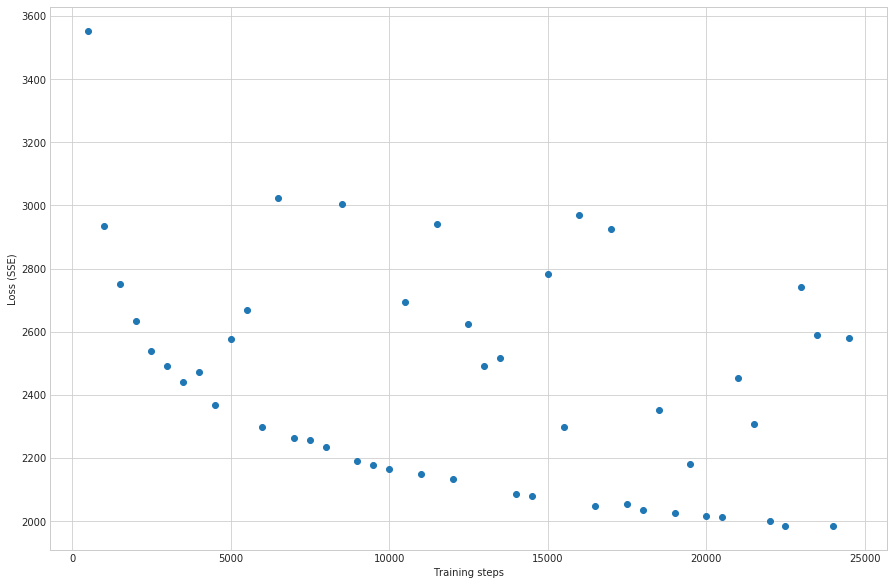

In [519]:
import matplotlib.pyplot as plt  
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 10]

loss_values = [ev['loss'] for ev in evaluations]  
training_steps = [ev['global_step'] for ev in evaluations]

plt.scatter(x=training_steps, y=loss_values)  
plt.xlabel('Training steps')  
plt.ylabel('Loss (SSE)')  
plt.show()  

In [524]:
pred = regressor.predict(input_fn=wx_input_fn(X_test,  
                                              num_epochs=1,
                                              shuffle=False))

predictions = np.array([p['predictions'][0] for p in pred])

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-24500


/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/dedeco/envs/tensorflow/local/lib/pyth

In [525]:

print("The Explained Variance: %.2f" % explained_variance_score(  
                                            y_test, predictions))  
print("The Mean Absolute Error: %.2f mm " % mean_absolute_error(  
                                            y_test, predictions))  
print("The Median Absolute Error: %.2f mm" % median_absolute_error(  
                                            y_test, predictions))

The Explained Variance: -0.28
The Mean Absolute Error: 1.48 mm 
The Median Absolute Error: 1.35 mm


In [526]:
predictions

array([-0.15395992,  1.6620954 ,  2.0048077 , ...,  1.7822126 ,
        0.8536084 ,  1.3935102 ], dtype=float32)

In [527]:
predictions.size

12901

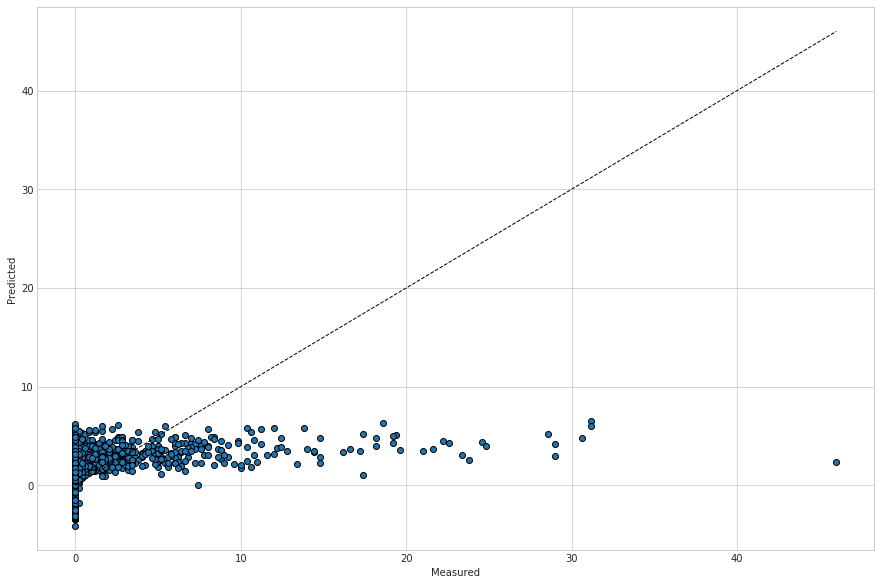

In [528]:
fig, ax = plt.subplots()
ax.scatter(y_test, predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()